In [1]:
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import manhattan_distances

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Reshape
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

sys.path.append("../")
sys.path.append("../dbal")
from query_methods import *
from training_models import *
from utils import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pd.set_option('display.max_columns', 500)

In [2]:
source = "synth"
target = "svhn"

encoder = load_model("../datasets/models_digits/encoder.h5")

Xs, ys = load_digits(source)
Xt, yt = load_digits(target)

Xs = encoder.predict(Xs[:,:,:,np.newaxis])
Xt = encoder.predict(Xt[:,:,:,np.newaxis])

Xs, ys, Xt, yt, convert_y = preprocessing_digits(Xs, ys, Xt, yt)

X = np.concatenate((Xs, Xt))
y = np.concatenate((ys, yt))

In [3]:
def get_base_model(input_shape=X.shape[1:], output_shape=10, activation="softmax", C=1):
    inputs = Input(input_shape)
    modeled = Dense(100, activation='relu',
                         kernel_constraint=MinMaxNorm(0, C),
                         bias_constraint=MinMaxNorm(0, C))(inputs)
    modeled = Dense(100, activation='relu',
                         kernel_constraint=MinMaxNorm(0, C),
                         bias_constraint=MinMaxNorm(0, C))(modeled)
    modeled = Dense(10, activation=activation,
                    kernel_constraint=MinMaxNorm(0, C),
                    bias_constraint=MinMaxNorm(0, C))(modeled)
    model = Model(inputs, modeled)
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=["accuracy"])
    return model

## Visualization

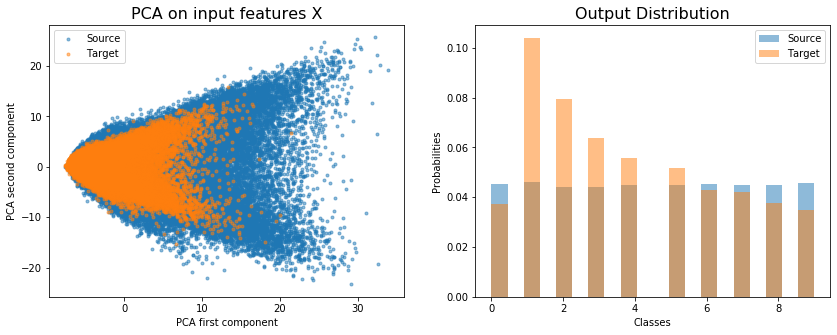

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

pca = PCA(2)
pca.fit(X)
Xs_pca = pca.transform(Xs)
Xt_pca = pca.transform(Xt)

ax1.plot(Xs_pca[:, 0], Xs_pca[:, 1], '.', alpha=0.5, label="Source")
ax1.plot(Xt_pca[:, 0], Xt_pca[:, 1], '.', alpha=0.5, label="Target")

ax2.hist(ys.argmax(1).ravel(), bins=20, alpha=0.5, density=False,
         weights=np.ones(len(ys)) * 1/len(y), label="Source")
ax2.hist(yt.argmax(1).ravel(), bins=20, alpha=0.5, density=False,
         weights=np.ones(len(yt)) * 1/len(y), label="Target")
    
ax1.set_title("PCA on input features X", fontsize=16)
ax1.set_xlabel(r"PCA first component")
ax1.set_ylabel(r"PCA second component")
ax2.set_title("Output Distribution", fontsize=16)
ax2.set_xlabel("Classes")
ax2.set_ylabel("Probabilities")
ax1.legend()
ax2.legend()
plt.show()

## Parameters

In [5]:
n_queries = 50
seed = 1
fit_params = dict(epochs=30,
                  batch_size=128,
                  verbose=0)
model = BalanceWeighting(get_base_model)

## Query Methods -- No Adversarial features

### Random

In [6]:
np.random.seed(seed); tf.random.set_seed(seed)
random = RandomQuery()
random.fit(Xt, Xs, ys, n_queries)
queries = random.predict(n_queries)

model.fit(Xs, ys, Xt[queries], yt[queries], **fit_params);

test_index = np.array(list(set(np.arange(len(Xt))) - set(queries)))
y_pred = convert_y(model.predict(Xt[test_index]))
y_true = convert_y(yt[test_index])
score_random = accuracy_score(y_true, y_pred)
print("Score on Unlabeled Target: %.3f"%score_random)

Score on Unlabeled Target: 0.766


### K-means

In [7]:
np.random.seed(seed); tf.random.set_seed(seed)
kmeans = KMeansQuery(minibatch=True)
kmeans.fit(Xt, Xs, ys, n_queries)
queries = kmeans.predict(n_queries)

model.fit(Xs, ys, Xt[queries], yt[queries], **fit_params);

test_index = np.array(list(set(np.arange(len(Xt))) - set(queries)))
y_pred = convert_y(model.predict(Xt[test_index]))
y_true = convert_y(yt[test_index])
score_kmeans = accuracy_score(y_true, y_pred)
print("Score on Unlabeled Target: %.3f"%score_kmeans)

Score on Unlabeled Target: 0.763


### Diversity

In [8]:
np.random.seed(seed); tf.random.set_seed(seed)
sub_index = np.random.choice(len(Xs), 1000, replace=False)
divers = DiversityQuery()
divers.fit(Xt, Xs[sub_index], ys[sub_index], n_queries)
queries = divers.predict(n_queries)

model.fit(Xs, ys, Xt[queries], yt[queries], **fit_params);

test_index = np.array(list(set(np.arange(len(Xt))) - set(queries)))
y_pred = convert_y(model.predict(Xt[test_index]))
y_true = convert_y(yt[test_index])
score_divers = accuracy_score(y_true, y_pred)
print("Score on Unlabeled Target: %.3f"%score_divers)

Score on Unlabeled Target: 0.757


### BVSB

In [9]:
np.random.seed(seed); tf.random.set_seed(seed)
bvsb_model = BVSB(get_base_model)
bvsb_model.fit(Xs, ys, **fit_params)
bvsb = OrderedQuery()
bvsb.fit(Xt, Xs, ys, n_queries, sample_weight=bvsb_model.uncertainties(Xt))
queries= bvsb.predict(n_queries)

model.fit(Xs, ys, Xt[queries], yt[queries], **fit_params);

test_index = np.array(list(set(np.arange(len(Xt))) - set(queries)))
y_pred = convert_y(model.predict(Xt[test_index]))
y_true = convert_y(yt[test_index])
score_bvsb = accuracy_score(y_true, y_pred)
print("Score on Unlabeled Target: %.3f"%score_bvsb)

Score on Unlabeled Target: 0.768


### K-centers

In [10]:
np.random.seed(seed); tf.random.set_seed(seed)
Xt_emb = bvsb_model.embeddings(Xt)
Xs_emb = bvsb_model.embeddings(Xs)
kcenters = KCentersQuery(nn_algorithm="kdt-forest", n_trees=50)
kcenters.fit(Xt_emb, Xs_emb, ys, n_queries)
queries = kcenters.predict(n_queries)

model.fit(Xs, ys, Xt[queries], yt[queries], **fit_params);

test_index = np.array(list(set(np.arange(len(Xt))) - set(queries)))
y_pred = convert_y(model.predict(Xt[test_index]))
y_true = convert_y(yt[test_index])
score_kcenters = accuracy_score(y_true, y_pred)
print("Score on Unlabeled Target: %.3f"%score_kcenters)

Score on Unlabeled Target: 0.768


### K-medoids W+E

In [11]:
np.random.seed(seed); tf.random.set_seed(seed)
Xt_emb = bvsb_model.embeddings(Xt)
Xs_emb = bvsb_model.embeddings(Xs)
kmedoids = KMedoidsAccelerated(verbose=1, nn_algorithm="kdt-forest", n_trees=50, batch_size_init=5000)
kmedoids.fit(Xt_emb, Xs_emb, ys, n_queries, sample_weight=bvsb_model.uncertainties(Xt))
queries = kmedoids.predict(n_queries)

model.fit(Xs, ys, Xt[queries], yt[queries], **fit_params);

test_index = np.array(list(set(np.arange(len(Xt))) - set(queries)))
y_pred = convert_y(model.predict(Xt[test_index]))
y_true = convert_y(yt[test_index])
score_kmedoids = accuracy_score(y_true, y_pred)
print("Score on Unlabeled Target: %.3f"%score_kmedoids)

Computation distance initial batch...
Queries number: 1 --- Objective: 26.484
Queries number: 6 --- Objective: 26.367
Queries number: 11 --- Objective: 26.271
Queries number: 16 --- Objective: 26.189
Queries number: 21 --- Objective: 26.109
Queries number: 26 --- Objective: 26.034
Queries number: 31 --- Objective: 25.959
Queries number: 36 --- Objective: 25.899
Queries number: 41 --- Objective: 25.832
Queries number: 46 --- Objective: 25.772
Epoch 0 -- Objective: 8.150
Epoch 1 -- Objective: 8.131
Epoch 2 -- Objective: 8.129
Score on Unlabeled Target: 0.773


### AADA

In [12]:
discriminator = load_model("../datasets/models_digits/discriminator.h5")
task = load_model("../datasets/models_digits/task.h5")
y_disc = discriminator.predict(Xt).ravel()
y_task = task.predict(Xt)

In [13]:
np.random.seed(seed); tf.random.set_seed(seed)
aada = OrderedQuery()
aada.fit(Xt, Xs, ys, n_queries, sample_weight=AADA(y_task, y_disc).uncertainties(Xt))
queries= aada.predict(n_queries)

model.fit(Xs, ys, Xt[queries], yt[queries], **fit_params);

test_index = np.array(list(set(np.arange(len(Xt))) - set(queries)))
y_pred = convert_y(model.predict(Xt[test_index]))
y_true = convert_y(yt[test_index])
score_bvsb = accuracy_score(y_true, y_pred)
print("Score on Unlabeled Target: %.3f"%score_bvsb)

Score on Unlabeled Target: 0.772


## Results Summary

Epoch 0 -- Objective: 8.129


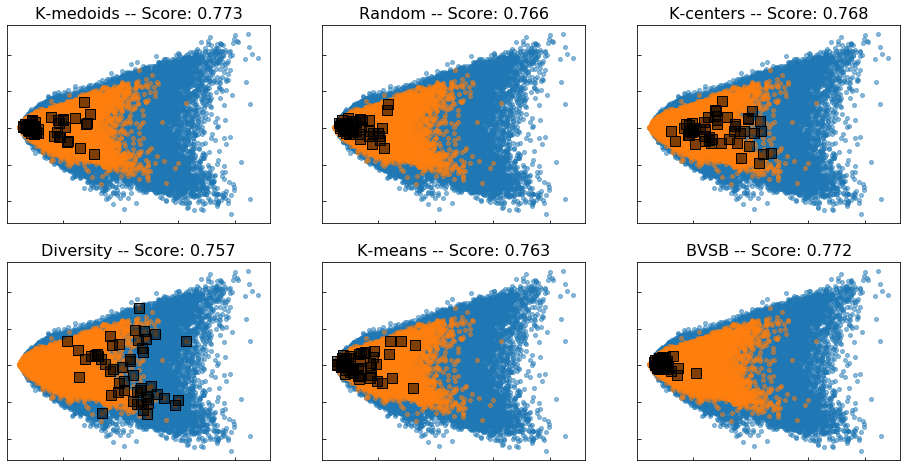

In [14]:
np.random.seed(seed)
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for method, ax, name, score in zip([kmedoids, random, kcenters, divers, kmeans, bvsb],
                           axes.ravel(),
                           ["K-medoids", "Random", "K-centers", "Diversity", "K-means", "BVSB"],
                                [score_kmedoids, score_random, score_kcenters, score_divers, score_kmeans, score_bvsb]):
    queries = method.predict(n_queries)
    ax.plot(Xs_pca[:, 0], Xs_pca[:, 1], '.', ms=8, label="Source", alpha=0.5)
    ax.plot(Xt_pca[:, 0], Xt_pca[:, 1], '.', ms=8, label="Target", alpha=0.5)
    ax.plot(Xt_pca[queries, 0], Xt_pca[queries, 1], 's', ms=10, markerfacecolor=(0,0,0,0.5), label="Queries", markeredgecolor=(0,0,0,1))
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(direction ='in')
    ax.set_title("%s -- Score: %.3f"%(name, score), fontsize=16)
    
    if method.__class__.__name__ == "KMedoidsGreedy":
        lgd = ax.legend(loc='upper left', framealpha=1, fontsize=14)
        
        lgd.legendHandles[0]._legmarker.set_markersize(20)
        lgd.legendHandles[1]._legmarker.set_markersize(20)
plt.show()